<a href="https://colab.research.google.com/github/CamachoTech/analise_exploratoria_de_dados/blob/main/analise_exploratoria_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

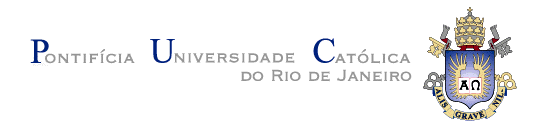

# MVP - Análise exploratória de dados e boas práticas

Euclides Camacho de Souza

## Definição do Problema
Este MVP tem por objetivo prever a quantidade de bicicletas compartilhas serão utilizadas em um determinado dia em Washington D.C. Para isso, um dataset parecido com o [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) foi montado, extraindo dados sobre o aluguel de bicicletas do site [Capital Bike](http://capitalbikeshare.com/system-data), e informações sobre o clima, visto que influencia no ato de alugar ou não, do site [freemeteo](http://www.freemeteo.com).

Vale ressaltar que os dados do UCI citado anteriormente, já estão na forma numérica, por esse motivo decidir extrair os dados das mesmas fontes e montar um dataset menos tratado, com o objetivo de aplicar os tratamentos aprendidos neste curso.




In [ ]:
# Imports

# Pacotes para tratamento de dados
import pandas as pd
import numpy as np

import sys
import os

# Conectando e montando o caminha do drive
from google.colab import drive
drive.mount(r'/content/drive', force_remount=True)

# Construção de gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt

# Exibição de dados no jupyter notebook
from IPython.display import display

# Pacote para identificação da cidade com a Longitude e Latitude
from geopy.geocoders import Nominatim

# Inciando Nominatim API
geolocator = Nominatim(user_agent='geopy/2.4.1')

# Como temos muitas linhas, alteramos o tempo de delay
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

Mounted at /content/drive


### Montagem do Dataset

O dataset final terá as seguintes informações:
- data
- estacao_ano : verão, inverno, primavera e outono
- ano: 2021 e 2022
- mes: meses do ano de 1 a 12
- feriado: se a data é feriado (True ou False)
- dia_util: se não for feriado ou final de semana (True ou False)

- descricao_clima: Chuva,
  - Neve,
  - Neve Chuva,
  - Nevoeiro Neve,
  - Nevoeiro Chuva,
  - Tempestade de raios Chuva,
  - Nevoeiro Tempestade de raios Chuva,
  - Nevoeiro Neve Chuva
  - Parcialmente nublado ou poucas nuvens
  - Nublado e raios
  - Nublado e sincelo

- temp_min_C: temperatura mínima do dia em °C
- temp_min_max: temperatura máxima do dia em °C
- vento_constante_km_h: velocidade do vento constante em km/h
- rajda_vento_km_h: rajada de vento em km/h
- volume_chuva:volume de chuva em mm
- espessura_neve: espessura de neve em mm

- qtd_casual: quantidade de usuários casuais
- qtd_registrado: quantidade de usuários registrados
- qtd_total: quantidade de usuários totais



#### Dados sobre as locações
Para chegar nos dados sobre aluguéis das bicicletas, foram realizados downloads de 24 pastas e unificados os arquivos csv com o código na célula seguinte, mas para não correr o risco de tratar o MVP, unificamos com o pandas.concat e salvamos no drive. Com isso, será uma consulta simples ao arquivo unificado com os dados de janeiro de 2021 até 31 de dezembro de 2022.


In [68]:
# Lendo todos os arquivos e unificando os dados
'''
part_1 = r'/content/drive/MyDrive/MVP/capital_bike_share/'
df = pd.read_csv(part_1 + 'capital_bike_share_unificado.csv')
'''

## Deletar as linhas que tenham alguma coorde-
## nada vazia/nula (NaN), pois não consiguimos
## identificar sua localização
'''
df = df.dropna(how='any')
df.reset_index(drop=True, inplace=True)
'''

# Criando a coluna data para cruzamento com as informações
## metereológicas
'''
df['started_at'] = df['started_at'].str[0:10]
'''

Agrupando a quantidade de usuários por dia para saber a quantidade de usuários casuais, registrados e totais.

In [69]:
# Selecionando parte do dataframe par contagem
'''
capital_bike_share = df[['started_at','ride_id','member_casual']]
'''
# Agrupando com groupby.agg para realizar a contagem
## de uma única vez
'''
capital_bike_share = capital_bike_share.pivot_table(values='ride_id',
        index='started_at', columns='member_casual', aggfunc='count')\
                                               .reset_index(drop=False)
'''
# Selecionando as colunas necessárias
'''
capital_bike_share = capital_bike_share[['started_at','casual','member']]
'''
# Renomeando as colunas
'''
capital_bike_share.columns = ['data','qtd_casual','qtd_registrado']
'''
# Total de aluguies
'''
capital_bike_share['qtd_total'] = capital_bike_share['qtd_casual'] + \
                                  capital_bike_share['qtd_registrado']
'''

In [71]:
capital_bike_share = pd.read_csv(r'https://github.com/CamachoTech/analise_exploratoria_de_dados/blob/main/bike_share_tratado.csv')

ParserError: ignored

#### Dados metereológicos

Os dados sobre a condição climática foram extraídos através de WebScraping, capturando as tabelas em formatos HTML e trasnformando para Pandas DataFrame. Da tabela capturada utilizaremos a data, temperaturas mínimas e máximas, velocidade do vento (e a velocidade máxima ou rajada de vento), volume de chuva, espessura da nece e a descrição do clima (chuva, neve, nublado, tempestade ...)

In [ ]:
# Lendo os dados metereológicos de Washington D.C
clima_tempo = pd.read_csv(part_1+'df_clima_tempo_mensal_diario.csv')

# Selecionando as colunas necessárias sobre o clima
clima_tempo = clima_tempo[[
      'Data', 'Temperatura mínima diária', 'Temperatura máxima diária',
       'Vento constante máximo', 'Rajada de vento máxima',
       'Precipitação diária total', 'Espessura de neve', 'Descrição']]

# Renomeando as colunas
clima_tempo.columns = ['data', 'temp_min_C','temp_max_C','vento_constante_km_h',
                       'rajada_vento_km_h','volume_chuva','espessura_neve',
                       'descricao_clima']

# Padronizando a coluna data
clima_tempo['data']  = clima_tempo['data'].str[6::] + '-'+ \
                               clima_tempo['data'].str[3:5]\
                          +'-'+ clima_tempo['data'].str[0:2]

Identificando a estação climática

In [ ]:
# Identificando a estação do ano identificados pelo mês,
## mas para uma maior precisa
# Verão
condicao = clima_tempo['data'].str[5:7]\
          .isin(['06', '07', '08'])
clima_tempo.loc[condicao,'estacao_ano']='verão'

# Outono
condicao = clima_tempo['data'].str[5:7]\
          .isin(['09', '10', '11'])
clima_tempo.loc[condicao,'estacao_ano']='outono'

# Inverno
condicao = clima_tempo['data'].str[5:7]\
          .isin(['12', '01', '02'])
clima_tempo.loc[condicao,'estacao_ano']='inverno'

# Primavera
condicao = clima_tempo['data'].str[5:7]\
          .isin(['03', '04', '05'])
clima_tempo.loc[condicao,'estacao_ano']='primavera'

#### Cruzando as informações de aluguéis e metereológicas
(unificando os dados em um único pandas dataframe)

In [ ]:
# Faremos inner, pois queremos saber a condição climática
capital_bike_share = pd.merge(
                              capital_bike_share,
                              clima_tempo,
                              how='inner',
                              on='data'
)

#### Cirando as colunas ano, mes, feriado e dia_util
Os feriados foram extraídos do site [dchr.dc.gov](https://dchr.dc.gov/page/holiday-schedules)

In [ ]:
# Coluna ano
capital_bike_share['ano'] = capital_bike_share['data'].str[0:4]

# Coluna mes
capital_bike_share['mes'] = capital_bike_share['data'].str[5:7]

# Feriado em Washington D.C
feriados = ['01-02','01-16','02-16', '02-20','04-17','05-29',
                '06-19','07-04','09-04','10-09','11-23','25']

capital_bike_share.loc[:, 'feriado']= False
condicao = capital_bike_share['data'].str[5::].isin([feriados])
capital_bike_share.loc[condicao, 'feriado']= True

# Dia útil
capital_bike_share.loc[:, 'dia_util'] = True

condicao_1 = capital_bike_share['data']\
                  .astype('datetime64[ns]')\
                  .dt.weekday>=6

condicao_2 = capital_bike_share['feriado'] == True

condicao = condicao_1 | condicao_2

capital_bike_share.loc[:, 'dia_util'] = False

Reordenando as colunas

In [ ]:
capital_bike_share = capital_bike_share[[
          'data','ano','mes', 'feriado','dia_util',
          'descricao_clima','temp_min_C', 'temp_max_C',
           'vento_constante_km_h','rajada_vento_km_h',
          'volume_chuva','espessura_neve','qtd_casual',
                         'qtd_registrado','qtd_total']]

#### Transformando colunas em tipos numéricos
Iremos transforma as colunas com informações sobre temperatura, velocidade do vento e espessura da neve em dados numpericos para facitar a visualização nos gráficos das análises exploratórias


In [ ]:
# Dados de temperatura para  tipo numérico
capital_bike_share['temp_min_C'] = capital_bike_share['temp_min_C']\
                                              .str.replace('°C','')\
                                                      .astype(float)

capital_bike_share['temp_max_C'] = capital_bike_share['temp_max_C']\
                                              .str.replace('°C','')\
                                                      .astype(float)


# Transformando as informações sobre velocidade do vento
capital_bike_share['vento_constante_km_h'] = \
                          capital_bike_share['vento_constante_km_h']\
                                            .str.replace(' Km/h','')\
                                                        .astype(float)
capital_bike_share['rajada_vento_km_h'] = \
                            capital_bike_share['rajada_vento_km_h']\
                                            .str.replace(' Km/h','')\
                                                        .astype(float)

# Transformando as colunas espessura_neve e volume_chuva
capital_bike_share['espessura_neve'] = \
                              capital_bike_share['espessura_neve']\
                                             .str.replace(',','.')\
                              .str.replace('mm|cm|m','',regex=True)\
                                                     .astype(float)
capital_bike_share['volume_chuva'] = \
                            capital_bike_share['volume_chuva']\
                            .str.replace(',','.')\
                            .str.replace('mm','',regex=True)\
                                               .astype(float)

#### Identificação dos eventos climáticos para os casos não identificados
Os dados capturados sobre o clima de um determinado dia tem mais de 500 casos classifcados como "eventos climáticos não informados", para resolver esse problema foi realizado mais um webScraping, mas desse vez na tabela com informções sobre a condicação climática ao longo do dia, para o príodo de 2021-01-01 até 2022-12-31.

In [ ]:
# Carregando arquivo csv com os eventos climáticos ao longo do dia
clima_tempo_dia_hora = pd.read_csv(part_1+'df_clima_tempo_por_dia_hora.csv')

Identificação do evento climático de acordo com o código

In [ ]:
condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(1',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Limpo'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(2',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Poucas nuvens'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(3',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Parcialemente nublado'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(4',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(7',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(8',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva forte'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(10',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Trovão'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(26',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(94',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Sincelo'

Agrupando todos os eventos climáticos por dia

In [ ]:
# Selecionando as colunas necessárias
clima_tempo_dia_hora = clima_tempo_dia_hora[['dia','descricao_detalhes']]

# Retirando as duplicidades de eventos no mesmo dia
clima_tempo_dia_hora.drop_duplicates(inplace=True)

# Ordenando pelo evento climático
clima_tempo_dia_hora.sort_values(by='descricao_detalhes', inplace = True)

<ipython-input-58-1631955512c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clima_tempo_dia_hora.drop_duplicates(inplace=True)


In [ ]:
# Agrupando os eventos climáticos identifcados no dia
clima_tempo_dia_hora['descricao_detalhes'] = clima_tempo_dia_hora.groupby(['dia'])\
                          ['descricao_detalhes'].transform(lambda x: ', '.join(x))

# Retirandos as linhas duplicados
clima_tempo_dia_hora.drop_duplicates(inplace = True)

A seguir iremos classificar os eventos climáticos com os seguintes tipos:
 - Chuva,
 - Neve,
 - Neve Chuva,
 - Nevoeiro Neve,
 - Nevoeiro Chuva,
 - Tempestade de raios Chuva,
 - Nevoeiro Tempestade de raios Chuva,
 - Nevoeiro Neve Chuva
 - Parcialmente nublado ou poucas nuvens
 - Nublado e raios
 - Nublado e sincelo

Para isso, visualizei os agrupamentos possíveis e fui classificando de acordo com as combinações dos eventos climáticos

In [ ]:
condicao = clima_tempo_dia_hora.descricao_detalhes.str.contains('Chuva, Nublado, Parcialemente nublado, Poucas nuvens',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
  .contains('Chuva, Nublado, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
              .contains('Chuva, Nublado, Parcialemente nublado',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'



condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Nublado, Parcialemente nublado, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'



condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Nublado, Parcialemente nublado, Poucas nuvens',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'



condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Nublado, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str.contains('Chuva, Nublado',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str.contains('Chuva, Nublado, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Nublado, Trovão|Chuva, Limpo, Parcialemente nublado, Poucas nuvens, Trovão',
                                                                          na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Nublado, Poucas nuvens|Chuva, Limpo, Nublado, Parcialemente nublado|Chuva, Limpo, Nublado',
                                                                                    na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens|Chuva, Neve, Nublado, Poucas nuvens|Chuva, Neve, Nublado, Parcialemente nublado|Chuva, Limpo, Neve, Nublado|Chuva, Neve, Nublado, Parcialemente nublado, Poucas nuvens|Chuva, Neve, Nublado',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes=='Limpo'
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Limpo'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Nublado, Parcialemente nublado, Poucas nuvens|Limpo, Parcialemente nublado, Poucas nuvens|Limpo, Poucas nuvensLimpo, Nublado, Parcialemente nublado|Limpo, Nublado, Poucas nuvens|Nublado, Parcialemente nublado, Poucas nuvens|Parcialemente nublado, Poucas nuvens'
,na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Parcialmente nublado ou poucas nuvens'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Poucas nuvens|Limpo, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Poucas nuvens'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Nublado',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Parcialemente nublado, Poucas nuvens, Trovão|Limpo, Nublado, Parcialemente nublado, Poucas nuvens, Trovão|Limpo, Parcialemente nublado, Poucas nuvens, Trovão|Nublado, Parcialemente nublado, Trovão',
                                                                  na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado e raios'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Nublado',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens|Neve, Nublado, Parcialemente nublado, Poucas nuvens|Neve, Nublado',
                                                                                                                  na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Nublado, Parcialemente nublado, Poucas nuvens, Sincelo', na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado e sincelo'


 Substituindo as informações de "eventos climáticos não informados" pela identificação realizada anteriormente no dataFrame capital_bike_share

In [ ]:
# Renomenado as colunas para crazemento com o dataFrame clima_tempo
clima_tempo_dia_hora.columns = ['data', 'descricaoDetalhes']

# Crauzando as tabelas com os dados metereológicos
capital_bike_share = pd.merge(
              capital_bike_share,
              clima_tempo_dia_hora,
              how='left',
              on='data'
)

condicao = capital_bike_share.descricao_clima == 'eventos climáticos não informados'

capital_bike_share.loc[condicao, 'descricao_clima'] = \
                            capital_bike_share.loc[condicao, 'descricaoDetalhes']

# Retirando a coluna 'descricaoDetalhes
capital_bike_share = capital_bike_share[[ \
                  'data', 'ano', 'mes', 'feriado', 'dia_util','descricao_clima',
       'temp_min_C', 'temp_max_C', 'vento_constante_km_h', 'rajada_vento_km_h',
       'volume_chuva', 'espessura_neve', 'qtd_casual', 'qtd_registrado','qtd_total'
                                      ]]

### Unifi